In [1]:
import math
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as pdist
import pyro.infer


c:\Users\toman\conda\envs\pml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def g(x):
    #return x
    return - np.sin(6 * np.pi * x) ** 2 + 6*x ** 2 - 5*x ** 4 + 1.5

In [3]:
def sample_datapoints(L, g, mu, std):
    x = np.array([(i-1)/(L-1) for i in range (1, L + 1)])
    epsilon = norm.rvs(loc=mu, scale=std, size=x.shape[0])
    y = g(x) + epsilon
    return train_test_split(x,y,test_size=10./30.)

In [4]:
def plot_refined(observed=None, predicted=None, model=None, kernel=None, prior_samples=0, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6))
        num_samples = 100
        x = np.linspace(0,1,num_samples)
        y = g(x) + np.random.normal(0, np.sqrt(0.01), size=num_samples)
        ax.plot(x, y)
    if observed:
        ax.plot(observed[0],observed[1], 'kx')
    if predicted:
        X_test = torch.linspace(-0.5, 1.5, 100).double()

        with torch.no_grad():
            mean, cov = model(X_test,full_cov=True, noiseless=False)
        
        std = cov.diag().sqrt()
        ax.plot(X_test.numpy(), mean.numpy(), 'r', lw=2)
        ax.fill_between(X_test.numpy(),(mean - 2.0 * std).numpy(), (mean + 2.0 * std).numpy(), color="C0", alpha=0.3)

    if prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 1.5, 100)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(100).diag()
        samples = pdist.MultivariateNormal(
            torch.zeros(100), covariance_matrix=cov
        ).sample(sample_shape=(prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5,1.5)


In [5]:
def map_estimation(gpr_model, steps):
    losses = []
    optimizer = torch.optim.Adam(gpr_model.parameters(), lr=1e-3)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    for i in range(steps):  # Perform MAP optimization
        optimizer.zero_grad()
        loss = loss_fn(gpr_model.model, gpr_model.guide)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            losses.append(loss.item())
            print(f"Step:{i} Loss:{loss.item()}")
    return gpr_model, losses

In [6]:
import math
def compute_log_likelihood(gpr_model, X_test, y_test):
    # Get full predictive mean and covariance (size NxN) at the test inputs
    mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)

    y_test_t = torch.tensor(y_test).double()

    diff = y_test_t - mean 
    diff = diff.unsqueeze(-1) 


    inv_cov = torch.inverse(cov)           
    logdet_cov = torch.logdet(cov)         
    N = y_test_t.shape[0]

    ll = -0.5 * (diff.transpose(-1,-2) @ inv_cov @ diff)  
    ll = ll.item()  

    ll -= 0.5 * logdet_cov.item()
    ll -= 0.5 * N * math.log(2.0 * math.pi) 

    return ll


In [7]:
def create_gp_model(X, y):
    pyro.clear_param_store()
    X = torch.tensor(X, dtype=torch.float)
    if X.dim() == 1:
        X = X.view(-1, 1)  # reshape to [N,1]
    y = torch.tensor(y, dtype=torch.float).view(-1)

    input_dim = X.shape[1]
    kernel = gp.kernels.Matern32(input_dim=input_dim)

    kernel.set_prior("variance", pdist.LogNormal(0.0, 1.0))    
    kernel.set_prior("lengthscale", pdist.LogNormal(-1.0, 0.5))  


    gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.01))

    return gpr

In [8]:
def parameter_sampling(X_train, y_train, num_samples=500, warmup_steps=200):
    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)


    # Define NUTS sampler
    gpr = create_gp_model(X_train, y_train)
    nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=1)

    # Run MCMC
    mcmc.run()

    # Extract posterior samples
    posterior_samples = mcmc.get_samples()
    return posterior_samples, mcmc

In [9]:
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

In [10]:
X_train, X_test, y_train, y_test =sample_datapoints(L=30,g=g,mu=0, std=0.01)

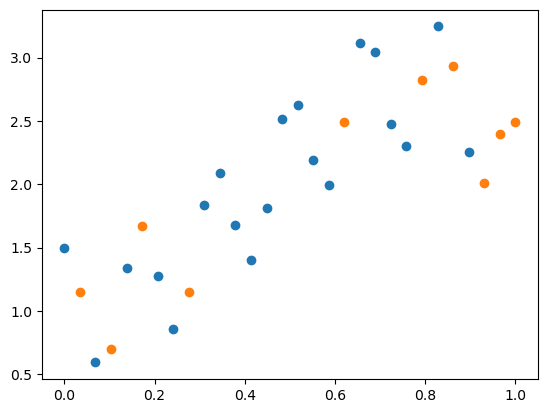

In [11]:
fig, ax = plt.subplots()
ax.plot(X_train, y_train, 'o')
ax.plot(X_test, y_test, 'o')

In [12]:
variance = pyro.sample("variance", pdist.LogNormal(0.0,1.0))
lengthscale = pyro.sample("lengthscale", pdist.LogNormal(-1.0, 0.5))

kernel = gp.kernels.Matern32(input_dim=1, variance=variance, lengthscale=lengthscale)

gp_model =  gp.models.GPRegression(torch.tensor(X_train), torch.tensor(y_train), kernel=kernel, noise=torch.tensor(0.01))


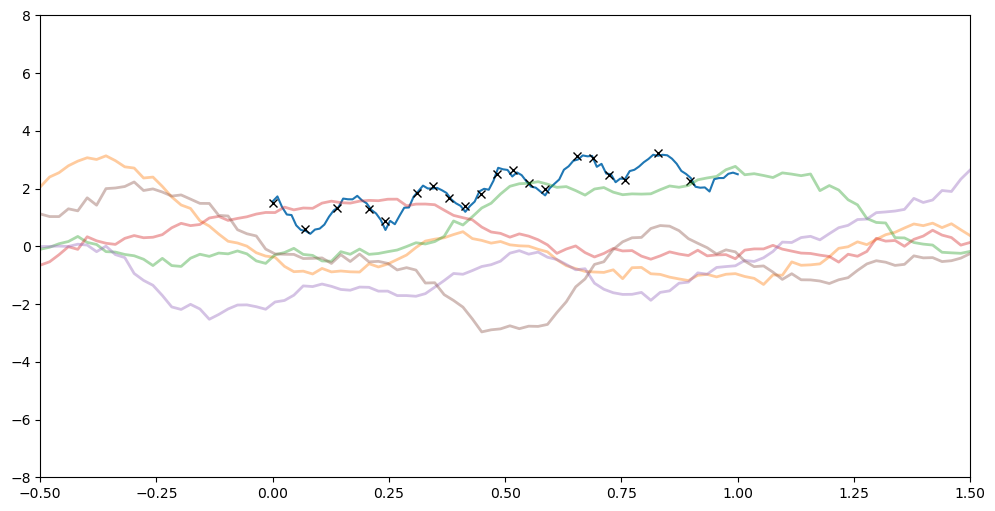

In [13]:
plot_refined(observed=[X_train, y_train], prior_samples=5, model=gp_model, kernel=kernel)
_ = plt.ylim((-8, 8))

In [14]:
gp_model_estimated, losses = map_estimation(gpr_model=gp_model,steps=10000)

print(f"Optimal parameters: Variance = {gp_model_estimated.kernel.variance.item()} Lengthscale = {gp_model_estimated.kernel.lengthscale.item()}")


Step:0 Loss:58.92501247325639
Step:10 Loss:57.55723854604787
Step:20 Loss:56.223388987768814
Step:30 Loss:54.92673471855346
Step:40 Loss:53.66903874379173
Step:50 Loss:52.4507817808348
Step:60 Loss:51.27167760002129
Step:70 Loss:50.13098839047185
Step:80 Loss:49.0277895605489
Step:90 Loss:47.961055866004045
Step:100 Loss:46.929800890510705
Step:110 Loss:45.9329865505101
Step:120 Loss:44.96961385417129
Step:130 Loss:44.03869652314934
Step:140 Loss:43.13928542541365
Step:150 Loss:42.27043180748781
Step:160 Loss:41.43123409870863
Step:170 Loss:40.620766806286646
Step:180 Loss:39.83818873368472
Step:190 Loss:39.08262507212447
Step:200 Loss:38.353239079186096
Step:210 Loss:37.649212586226696
Step:220 Loss:36.9697649707376
Step:230 Loss:36.31412684347029
Step:240 Loss:35.68152084377396
Step:250 Loss:35.071220727153445
Step:260 Loss:34.482514929527596
Step:270 Loss:33.914695414490964
Step:280 Loss:33.367075811112116
Step:290 Loss:32.83901199159598
Step:300 Loss:32.32984895442531
Step:310 Loss

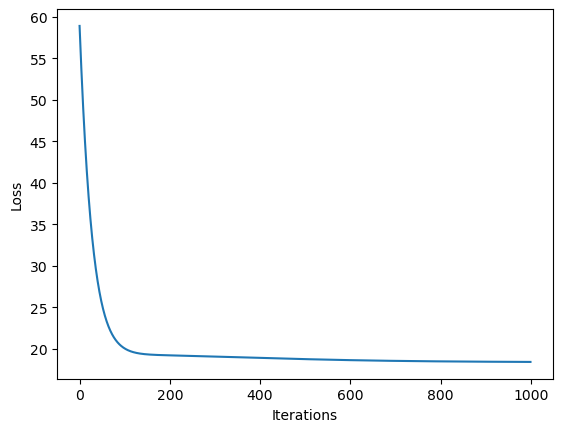

In [15]:
plot_loss(losses)

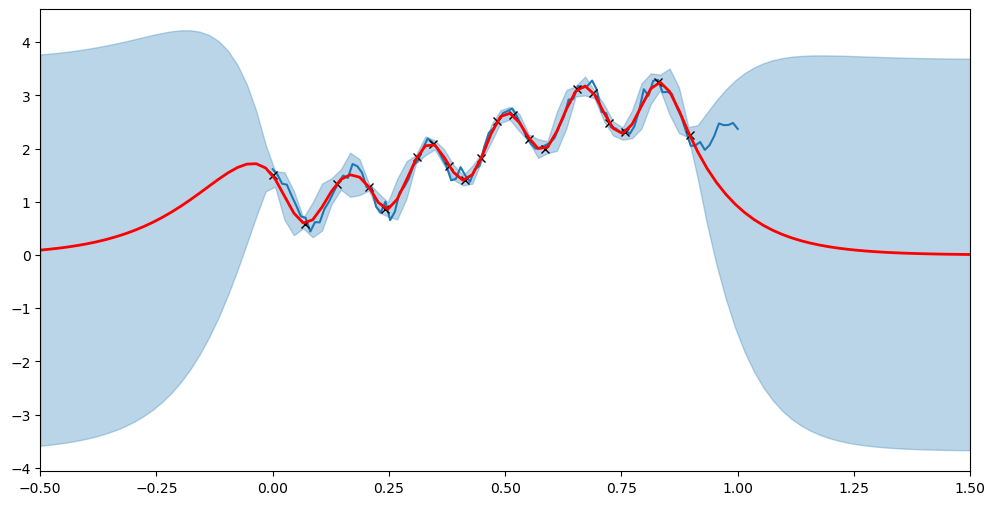

In [16]:
plot_refined(model=gp_model_estimated, observed=[X_train,y_train], predicted=True, kernel=kernel)

In [17]:
# MAP posterior prediction
log_likelihood = compute_log_likelihood(gp_model_estimated,X_test,y_test)
print(f"MAP log-likelihood: {log_likelihood}")


MAP log-likelihood: 2.2294383446585684


In [19]:
samples, mcmc = parameter_sampling(X_train,y_train) 

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float).view(-1)
c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\parameterized.py:106: UserWarning: The method `self.set_prior(variance, prior)` has been deprecated in favor of `self.variance = PyroSample(prior)`.
  warnings.warn(
c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\parameterized.py:106: UserWarning: The method `self.set_prior(lengthscale, prior)` has 

c:\Users\toman\conda\envs\pml\lib\site-packages\arviz\data\io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


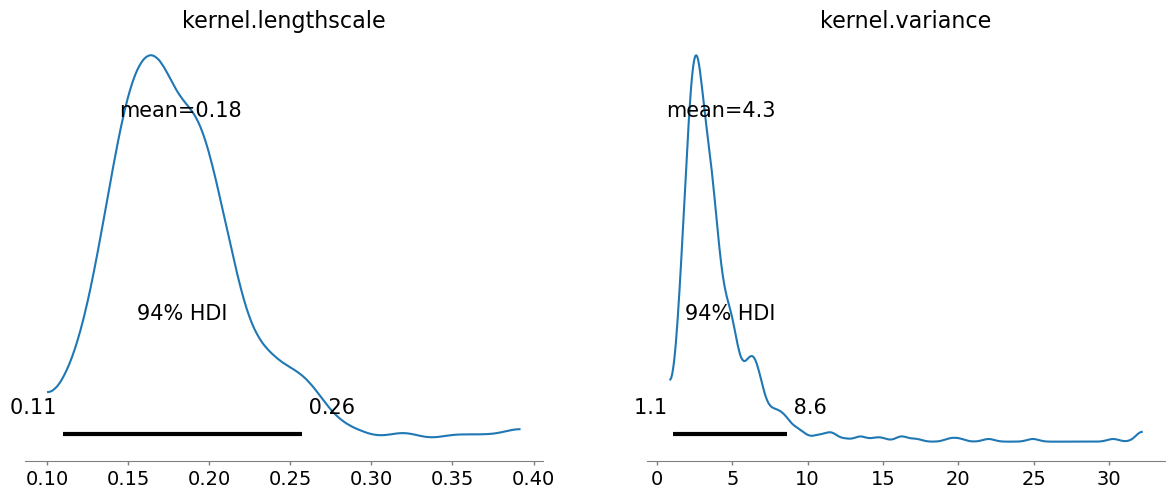

In [20]:
# TODO use arviz to summarize and investigate: plot
import arviz
data = arviz.from_pyro(mcmc)

summary = arviz.summary(data)

arviz.plot_posterior(data)
plt.show()

In [21]:
# Compute log-likelihood from all parameters
log_likelihood_list = []
for i in range(len(samples['kernel.variance'])):
    pyro.clear_param_store()
    variance = samples['kernel.variance'][i]
    lengthscale = samples['kernel.lengthscale'][i]

    kernel = gp.kernels.Matern32(input_dim=1, variance=variance, lengthscale=lengthscale)
    gp_model = gp.models.GPRegression(torch.tensor(X_train), torch.tensor(y_train), kernel=kernel, noise=torch.tensor(0.01)) 
    
    log_likelihood = compute_log_likelihood(gp_model,X_test=X_test,y_test=y_test)
    log_likelihood_list.append(log_likelihood)

average_log_likelihood = torch.tensor(log_likelihood_list).mean()

In [22]:
average_log_likelihood

tensor(0.7498)

Step:0 Loss:98.12021813102714
Step:10 Loss:96.84878462290794
Step:20 Loss:95.59291202965055
Step:30 Loss:94.35412712008758
Step:40 Loss:93.13311095687587
Step:50 Loss:91.93014571080724
Step:60 Loss:90.74495743786886
Step:70 Loss:89.5772899775861
Step:80 Loss:88.42664733717771
Step:90 Loss:87.2925425191838
Step:100 Loss:86.1745082624494
Step:110 Loss:85.07210635959677
Step:120 Loss:83.98479025061553
Step:130 Loss:82.91214583768433
Step:140 Loss:81.85373351418605
Step:150 Loss:80.80911604964226
Step:160 Loss:79.77785333442475
Step:170 Loss:78.75956445571295
Step:180 Loss:77.75383784001822
Step:190 Loss:76.76029691137175
Step:200 Loss:75.77852308560185
Step:210 Loss:74.8082257397725
Step:220 Loss:73.84898312401992
Step:230 Loss:72.90048680133313
Step:240 Loss:71.9624123491237
Step:250 Loss:71.03444114437927
Step:260 Loss:70.11628931828753
Step:270 Loss:69.20755520800871
Step:280 Loss:68.30814550993074
Step:290 Loss:67.41773863484647
Step:300 Loss:66.53602559445662
Step:310 Loss:65.6627358

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9960 Loss:15.523913267809197
Step:9970 Loss:15.523079744776416
Step:9980 Loss:15.522249004577638
Step:9990 Loss:15.521421507530292


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:09, 76.45it/s, step size=4.15e-01, acc. prob=0.936]


Step:0 Loss:94.75411144995795
Step:10 Loss:93.62152305238523
Step:20 Loss:92.50479910252702
Step:30 Loss:91.40533709865528
Step:40 Loss:90.3238717385499
Step:50 Loss:89.26055587958916
Step:60 Loss:88.21531661259685
Step:70 Loss:87.18767576465703
Step:80 Loss:86.17728307311536
Step:90 Loss:85.183666472613
Step:100 Loss:84.20635482813367
Step:110 Loss:83.24487951783391
Step:120 Loss:82.298793967449
Step:130 Loss:81.36765567323266
Step:140 Loss:80.45103548403843
Step:150 Loss:79.54849514726946
Step:160 Loss:78.65952960485704
Step:170 Loss:77.78376424205243
Step:180 Loss:76.92085371066923
Step:190 Loss:76.0704024520011
Step:200 Loss:75.23204454790742
Step:210 Loss:74.40548302229288
Step:220 Loss:73.59022185312215
Step:230 Loss:72.78593578554435
Step:240 Loss:71.9922806909081
Step:250 Loss:71.20892583440317
Step:260 Loss:70.43552578278288
Step:270 Loss:69.67172939934304
Step:280 Loss:68.91722530638376
Step:290 Loss:68.17171595220901
Step:300 Loss:67.43482896579923
Step:310 Loss:66.706323398

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9970 Loss:20.67451746153201
Step:9980 Loss:20.673836349852884
Step:9990 Loss:20.6731563294437


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:09, 74.45it/s, step size=6.72e-01, acc. prob=0.920] 


Step:0 Loss:92.57128460579554
Step:10 Loss:91.29637491543488
Step:20 Loss:90.04153135453114
Step:30 Loss:88.80852981913111
Step:40 Loss:87.59825851922595
Step:50 Loss:86.41099617055721
Step:60 Loss:85.24647038665901
Step:70 Loss:84.10422901894287
Step:80 Loss:82.98371541045948
Step:90 Loss:81.88434262563403
Step:100 Loss:80.80553135101388
Step:110 Loss:79.74668109645168
Step:120 Loss:78.70717462408194
Step:130 Loss:77.68652304793622
Step:140 Loss:76.68418903709583
Step:150 Loss:75.69970208853013
Step:160 Loss:74.7325096840373
Step:170 Loss:73.78220703086043
Step:180 Loss:72.848296788294
Step:190 Loss:71.93037228074249
Step:200 Loss:71.02797832830754
Step:210 Loss:70.14073084020002
Step:220 Loss:69.2682277544647
Step:230 Loss:68.41011214233632
Step:240 Loss:67.56600792470888
Step:250 Loss:66.73555964956824
Step:260 Loss:65.91843126907163
Step:270 Loss:65.11430696262588
Step:280 Loss:64.32286230176449
Step:290 Loss:63.54380689314422
Step:300 Loss:62.77685590996013
Step:310 Loss:62.021714

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9950 Loss:17.13523981105172
Step:9960 Loss:17.134448670093505
Step:9970 Loss:17.1336604598454
Step:9980 Loss:17.13287494566339
Step:9990 Loss:17.132091753324936


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:09, 72.69it/s, step size=6.72e-01, acc. prob=0.923] 


Step:0 Loss:106.04777959176067
Step:10 Loss:104.79463197406035
Step:20 Loss:103.55714473743782
Step:30 Loss:102.33665666167306
Step:40 Loss:101.13378821391322
Step:50 Loss:99.94889880984812
Step:60 Loss:98.78171894981708
Step:70 Loss:97.6319427002579
Step:80 Loss:96.49909872453172
Step:90 Loss:95.38269642991523
Step:100 Loss:94.28235576380195
Step:110 Loss:93.19740903138528
Step:120 Loss:92.12749175457324
Step:130 Loss:91.07202931268876
Step:140 Loss:90.0305969256446
Step:150 Loss:89.0026979393662
Step:160 Loss:87.98786905196724
Step:170 Loss:86.98565344442918
Step:180 Loss:85.99557871467911
Step:190 Loss:85.01720566121519
Step:200 Loss:84.05008906547312
Step:210 Loss:83.09374303755368
Step:220 Loss:82.14777568945286
Step:230 Loss:81.21167983527079
Step:240 Loss:80.28506807645226
Step:250 Loss:79.36746986505447
Step:260 Loss:78.45849486026931
Step:270 Loss:77.55767219747473
Step:280 Loss:76.66463996396185
Step:290 Loss:75.77892757820112
Step:300 Loss:74.90017212506926
Step:310 Loss:74.

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:0 Loss:108.83721458992518
Step:10 Loss:107.49466783692858
Step:20 Loss:106.17053114128744
Step:30 Loss:104.86631564371501
Step:40 Loss:103.58283008717228
Step:50 Loss:102.32032015280664
Step:60 Loss:101.07862077668219
Step:70 Loss:99.85714397441
Step:80 Loss:98.65549769242807
Step:90 Loss:97.47310023998058
Step:100 Loss:96.30937973087501
Step:110 Loss:95.16362909188027
Step:120 Loss:94.03533148998943
Step:130 Loss:92.92402170755224
Step:140 Loss:91.82915301156564
Step:150 Loss:90.75018798792655
Step:160 Loss:89.68659118278366
Step:170 Loss:88.63784114677631
Step:180 Loss:87.60341852116264
Step:190 Loss:86.5828854199259
Step:200 Loss:85.57577131834188
Step:210 Loss:84.58153148082746
Step:220 Loss:83.59973654350121
Step:230 Loss:82.62987520047028
Step:240 Loss:81.67156760328156
Step:250 Loss:80.72427987268031
Step:260 Loss:79.78761505962684
Step:270 Loss:78.86111668742713
Step:280 Loss:77.94435570208277
Step:290 Loss:77.03685436310204
Step:300 Loss:76.13824159910973
Step:310 Loss:75

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9970 Loss:17.863236941978194
Step:9980 Loss:17.862259191874113
Step:9990 Loss:17.86128508198091


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:09, 76.11it/s, step size=5.11e-01, acc. prob=0.933]


Step:0 Loss:93.54661071052513
Step:10 Loss:92.38697649181769
Step:20 Loss:91.24341920558106
Step:30 Loss:90.11747021265911
Step:40 Loss:89.00993217597689
Step:50 Loss:87.9210554730189
Step:60 Loss:86.8506129294482
Step:70 Loss:85.79846992806432
Step:80 Loss:84.76406552913625
Step:90 Loss:83.74697190092618
Step:100 Loss:82.74674421741307
Step:110 Loss:81.76290141647041
Step:120 Loss:80.7950823535256
Step:130 Loss:79.84275830909968
Step:140 Loss:78.9054850816726
Step:150 Loss:77.98301165806805
Step:160 Loss:77.07478591656913
Step:170 Loss:76.18040903014204
Step:180 Loss:75.29962126170753
Step:190 Loss:74.43194375721743
Step:200 Loss:73.5769699785471
Step:210 Loss:72.73447722860506
Step:220 Loss:71.90395861295868
Step:230 Loss:71.08519184791353
Step:240 Loss:70.2777372023377
Step:250 Loss:69.48129442568569
Step:260 Loss:68.69551139051215
Step:270 Loss:67.9201026364083
Step:280 Loss:67.15473215720965
Step:290 Loss:66.39907709447354
Step:300 Loss:65.65285800326974
Step:310 Loss:64.915713741

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9970 Loss:18.281828486537187
Step:9980 Loss:18.281001358541083
Step:9990 Loss:18.28017698519139


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:09, 76.20it/s, step size=4.02e-01, acc. prob=0.913] 


Step:0 Loss:102.41774988122316
Step:10 Loss:100.9716883083725
Step:20 Loss:99.54993199779547
Step:30 Loss:98.15475885020652
Step:40 Loss:96.78742681456926
Step:50 Loss:95.44814027964301
Step:60 Loss:94.13667026226751
Step:70 Loss:92.85252419915885
Step:80 Loss:91.59499461172592
Step:90 Loss:90.36341689643412
Step:100 Loss:89.15709274433479
Step:110 Loss:87.9752897623515
Step:120 Loss:86.81728038343483
Step:130 Loss:85.68247799920516
Step:140 Loss:84.57023128236926
Step:150 Loss:83.47996225039665
Step:160 Loss:82.41093351188442
Step:170 Loss:81.3626022282286
Step:180 Loss:80.33444158719755
Step:190 Loss:79.32593668146029
Step:200 Loss:78.33653148368664
Step:210 Loss:77.3656997695388
Step:220 Loss:76.41291608064756
Step:230 Loss:75.47771285771996
Step:240 Loss:74.55959501772352
Step:250 Loss:73.65817257526965
Step:260 Loss:72.77292540871942
Step:270 Loss:71.90349015902044
Step:280 Loss:71.04938388203172
Step:290 Loss:70.21021827617834
Step:300 Loss:69.38562016623864
Step:310 Loss:68.5752

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9990 Loss:18.663490098441574


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:10, 69.01it/s, step size=4.51e-01, acc. prob=0.926]


Step:0 Loss:94.80376508930429
Step:10 Loss:93.66533613512597
Step:20 Loss:92.54283416946748
Step:30 Loss:91.43756366936493
Step:40 Loss:90.35039147254705
Step:50 Loss:89.28144142309381
Step:60 Loss:88.23049145606824
Step:70 Loss:87.19720726786463
Step:80 Loss:86.18106182498724
Step:90 Loss:85.18163977721352
Step:100 Loss:84.19840730104882
Step:110 Loss:83.23090642792233
Step:120 Loss:82.27859652034365
Step:130 Loss:81.34103381659207
Step:140 Loss:80.41778529032169
Step:150 Loss:79.5083591377204
Step:160 Loss:78.61230820638684
Step:170 Loss:77.72920722324606
Step:180 Loss:76.85863667065576
Step:190 Loss:76.00013807197153
Step:200 Loss:75.15327670612297
Step:210 Loss:74.31769256678359
Step:220 Loss:73.49293737714939
Step:230 Loss:72.67858333315927
Step:240 Loss:71.87432892983303
Step:250 Loss:71.07964598949586
Step:260 Loss:70.29418838325134
Step:270 Loss:69.51754234945957
Step:280 Loss:68.74934932916659
Step:290 Loss:67.9891938318772
Step:300 Loss:67.23667766848429
Step:310 Loss:66.4914

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9960 Loss:18.535590175104282
Step:9970 Loss:18.534788732989774
Step:9980 Loss:18.533989883189978
Step:9990 Loss:18.5331934607162


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:10, 66.90it/s, step size=5.42e-01, acc. prob=0.945]


Step:0 Loss:103.1839558749819
Step:10 Loss:101.83046574685434
Step:20 Loss:100.49723043424544
Step:30 Loss:99.18610371999576
Step:40 Loss:97.89800071019883
Step:50 Loss:96.63307292806157
Step:60 Loss:95.39105774371133
Step:70 Loss:94.17144424629917
Step:80 Loss:92.97366971443765
Step:90 Loss:91.79702949796607
Step:100 Loss:90.64089187371555
Step:110 Loss:89.50464969464068
Step:120 Loss:88.38766241090642
Step:130 Loss:87.28935651370524
Step:140 Loss:86.20919899759483
Step:150 Loss:85.1466061156025
Step:160 Loss:84.10101725896942
Step:170 Loss:83.07199405997027
Step:180 Loss:82.05895201950042
Step:190 Loss:81.06147999500575
Step:200 Loss:80.07905760900994
Step:210 Loss:79.11122691586488
Step:220 Loss:78.15760278906387
Step:230 Loss:77.21771785468925
Step:240 Loss:76.29113200875254
Step:250 Loss:75.3774617803847
Step:260 Loss:74.47632241648927
Step:270 Loss:73.58734426130495
Step:280 Loss:72.71014049873867
Step:290 Loss:71.84433253784094
Step:300 Loss:70.98960058417302
Step:310 Loss:70.14

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9960 Loss:18.65740885388126
Step:9970 Loss:18.656673649308175
Step:9980 Loss:18.655940139240023
Step:9990 Loss:18.65520855974057


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:10, 68.33it/s, step size=5.52e-01, acc. prob=0.932]


Step:0 Loss:90.09568348838405
Step:10 Loss:88.88474401976886
Step:20 Loss:87.69223120813066
Step:30 Loss:86.5199431602341
Step:40 Loss:85.3686569797806
Step:50 Loss:84.23865470527667
Step:60 Loss:83.12976855317063
Step:70 Loss:82.04159073213445
Step:80 Loss:80.9735946868739
Step:90 Loss:79.92525183419895
Step:100 Loss:78.89608573269403
Step:110 Loss:77.88550635778239
Step:120 Loss:76.89306450948882
Step:130 Loss:75.91821393822964
Step:140 Loss:74.960511241961
Step:150 Loss:74.01946120102701
Step:160 Loss:73.0946629553114
Step:170 Loss:72.18563873469137
Step:180 Loss:71.29199576624038
Step:190 Loss:70.41328403754324
Step:200 Loss:69.54916188013601
Step:210 Loss:68.69921537483577
Step:220 Loss:67.86305436744712
Step:230 Loss:67.04035583121143
Step:240 Loss:66.2307961170121
Step:250 Loss:65.43395937808147
Step:260 Loss:64.6495510324597
Step:270 Loss:63.87730386807766
Step:280 Loss:63.116844623201196
Step:290 Loss:62.36790534817335
Step:300 Loss:61.63017170332658
Step:310 Loss:60.903376750

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9990 Loss:17.18588908832703


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:09, 75.39it/s, step size=5.09e-01, acc. prob=0.929]


Step:0 Loss:93.15470447877719
Step:10 Loss:92.07744324769374
Step:20 Loss:91.0148699828528
Step:30 Loss:89.96821960132345
Step:40 Loss:88.9382966837498
Step:50 Loss:87.92525269447175
Step:60 Loss:86.92888556065357
Step:70 Loss:85.94891113630652
Step:80 Loss:84.984854260713
Step:90 Loss:84.03630316482572
Step:100 Loss:83.10280195439105
Step:110 Loss:82.1838840591245
Step:120 Loss:81.27911942946723
Step:130 Loss:80.38807876029233
Step:140 Loss:79.51029763010283
Step:150 Loss:78.64536236896961
Step:160 Loss:77.79286989094393
Step:170 Loss:76.9523181061964
Step:180 Loss:76.12342630011447
Step:190 Loss:75.30559437318064
Step:200 Loss:74.49854480896475
Step:210 Loss:73.70181756263234
Step:220 Loss:72.91506660667312
Step:230 Loss:72.13783676662578
Step:240 Loss:71.36972157792474
Step:250 Loss:70.61029843493024
Step:260 Loss:69.85915784705846
Step:270 Loss:69.11588099876295
Step:280 Loss:68.38004765269241
Step:290 Loss:67.65125583910311
Step:300 Loss:66.92910162205769
Step:310 Loss:66.21314739

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9970 Loss:20.681619077084193
Step:9980 Loss:20.680998934758833
Step:9990 Loss:20.680379885245756


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:10, 66.48it/s, step size=5.92e-01, acc. prob=0.918]


Step:0 Loss:97.5559647841497
Step:10 Loss:96.33298099797207
Step:20 Loss:95.12610567977381
Step:30 Loss:93.93674684789818
Step:40 Loss:92.76570261034078
Step:50 Loss:91.61323648166928
Step:60 Loss:90.47921498480788
Step:70 Loss:89.36325814187245
Step:80 Loss:88.26503281788713
Step:90 Loss:87.18401684952697
Step:100 Loss:86.11974591488675
Step:110 Loss:85.07178892285629
Step:120 Loss:84.03969817458149
Step:130 Loss:83.02298174777611
Step:140 Loss:82.02121487486428
Step:150 Loss:81.03402252823389
Step:160 Loss:80.06098405062922
Step:170 Loss:79.10164648914623
Step:180 Loss:78.15563595883685
Step:190 Loss:77.22258521998971
Step:200 Loss:76.30208447009959
Step:210 Loss:75.39378441754474
Step:220 Loss:74.49732800083973
Step:230 Loss:73.61233778896379
Step:240 Loss:72.73851685499623
Step:250 Loss:71.8754678635348
Step:260 Loss:71.02287887335018
Step:270 Loss:70.1804450810271
Step:280 Loss:69.34784082345321
Step:290 Loss:68.5247638911947
Step:300 Loss:67.7109219808905
Step:310 Loss:66.9060191

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9960 Loss:19.068897103141747
Step:9970 Loss:19.068295484880966
Step:9980 Loss:19.067694980311614
Step:9990 Loss:19.067095673328936


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:10, 66.46it/s, step size=6.51e-01, acc. prob=0.931]


Step:0 Loss:89.02851238047379
Step:10 Loss:87.89361185093017
Step:20 Loss:86.77569304113592
Step:30 Loss:85.676266614598
Step:40 Loss:84.59623031781688
Step:50 Loss:83.53585796670103
Step:60 Loss:82.49506971333375
Step:70 Loss:81.47348071765556
Step:80 Loss:80.47075463688759
Step:90 Loss:79.48643508644574
Step:100 Loss:78.52005924846954
Step:110 Loss:77.57117046140573
Step:120 Loss:76.63937556440492
Step:130 Loss:75.72421882323269
Step:140 Loss:74.82533971832156
Step:150 Loss:73.94231049643486
Step:160 Loss:73.0747326313175
Step:170 Loss:72.22232900672788
Step:180 Loss:71.38464999485288
Step:190 Loss:70.5613736400733
Step:200 Loss:69.7521717003122
Step:210 Loss:68.95663125087499
Step:220 Loss:68.17451896368219
Step:230 Loss:67.40546508150459
Step:240 Loss:66.649221513512
Step:250 Loss:65.90546031692298
Step:260 Loss:65.17387194027538
Step:270 Loss:64.45420696560629
Step:280 Loss:63.74615574395658
Step:290 Loss:63.049454621747465
Step:300 Loss:62.363865971160365
Step:310 Loss:61.6890992

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9990 Loss:20.305500736427334


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:09, 70.36it/s, step size=6.62e-01, acc. prob=0.944]


Step:0 Loss:100.83224127585075
Step:10 Loss:99.57122200565766
Step:20 Loss:98.3286069872872
Step:30 Loss:97.10607238428254
Step:40 Loss:95.90450285169217
Step:50 Loss:94.72394312411578
Step:60 Loss:93.56420792123288
Step:70 Loss:92.42479709366998
Step:80 Loss:91.3051032020166
Step:90 Loss:90.20458806440226
Step:100 Loss:89.12261350439874
Step:110 Loss:88.05854705473413
Step:120 Loss:87.011853999594
Step:130 Loss:85.98197546542707
Step:140 Loss:84.96836050966019
Step:150 Loss:83.97047468289347
Step:160 Loss:82.98779545102852
Step:170 Loss:82.01987859681964
Step:180 Loss:81.06618472107323
Step:190 Loss:80.12622848259228
Step:200 Loss:79.19959301147463
Step:210 Loss:78.28579133187344
Step:220 Loss:77.38443321373956
Step:230 Loss:76.49500988882922
Step:240 Loss:75.61717402306321
Step:250 Loss:74.75047212905739
Step:260 Loss:73.89455558181626
Step:270 Loss:73.04896299334527
Step:280 Loss:72.21332423413415
Step:290 Loss:71.3872767651746
Step:300 Loss:70.57047221483376
Step:310 Loss:69.762499

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9990 Loss:18.73686639198963


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:09, 74.76it/s, step size=7.35e-01, acc. prob=0.920] 


Step:0 Loss:94.41943076027711
Step:10 Loss:93.23300083143582
Step:20 Loss:92.06447881390109
Step:30 Loss:90.915412282968
Step:40 Loss:89.78650614135759
Step:50 Loss:88.67802431391748
Step:60 Loss:87.58961890388838
Step:70 Loss:86.5209411382026
Step:80 Loss:85.47138457626657
Step:90 Loss:84.44038747715635
Step:100 Loss:83.42737145838768
Step:110 Loss:82.43170988807117
Step:120 Loss:81.45284676994127
Step:130 Loss:80.49035514696848
Step:140 Loss:79.5437127642227
Step:150 Loss:78.61242563056474
Step:160 Loss:77.69584929311459
Step:170 Loss:76.79366095077008
Step:180 Loss:75.90540063795962
Step:190 Loss:75.03060219409636
Step:200 Loss:74.16880440041533
Step:210 Loss:73.3195819005411
Step:220 Loss:72.482482537351
Step:230 Loss:71.65708399603596
Step:240 Loss:70.84294509474107
Step:250 Loss:70.03978191668085
Step:260 Loss:69.2471340823367
Step:270 Loss:68.46462521686735
Step:280 Loss:67.6918983753529
Step:290 Loss:66.92854127267623
Step:300 Loss:66.17423350784482
Step:310 Loss:65.42860294738

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9980 Loss:17.60059020586231
Step:9990 Loss:17.599655253082535


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:09, 72.88it/s, step size=5.82e-01, acc. prob=0.935]


Step:0 Loss:75.35760534827607
Step:10 Loss:74.36363939966863
Step:20 Loss:73.38556016740057
Step:30 Loss:72.42496598741477
Step:40 Loss:71.4826135267723
Step:50 Loss:70.55877379260173
Step:60 Loss:69.65340775095292
Step:70 Loss:68.76618773965684
Step:80 Loss:67.89667763433847
Step:90 Loss:67.0444905572312
Step:100 Loss:66.20924164464313
Step:110 Loss:65.39050523059916
Step:120 Loss:64.58789531888202
Step:130 Loss:63.80100551799805
Step:140 Loss:63.029489924920526
Step:150 Loss:62.27293241434913
Step:160 Loss:61.53097994150103
Step:170 Loss:60.80331974669468
Step:180 Loss:60.08958121072329
Step:190 Loss:59.38944204369487
Step:200 Loss:58.70255903340501
Step:210 Loss:58.02865038739232
Step:220 Loss:57.36743698952845
Step:230 Loss:56.718541445620076
Step:240 Loss:56.08174014950072
Step:250 Loss:55.4567513796571
Step:260 Loss:54.843261939317486
Step:270 Loss:54.24100887125995
Step:280 Loss:53.64977322903899
Step:290 Loss:53.06929530504173
Step:300 Loss:52.49930780381548
Step:310 Loss:51.93

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9990 Loss:13.606768632446009


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:09, 75.80it/s, step size=4.24e-01, acc. prob=0.941] 


Step:0 Loss:88.04630870848361
Step:10 Loss:86.9423923029519
Step:20 Loss:85.85418320788294
Step:30 Loss:84.78318661728312
Step:40 Loss:83.73023260211382
Step:50 Loss:82.69543930499938
Step:60 Loss:81.67865233484149
Step:70 Loss:80.67953506164223
Step:80 Loss:79.69766930186896
Step:90 Loss:78.73258410456512
Step:100 Loss:77.78385081181366
Step:110 Loss:76.85097438143521
Step:120 Loss:75.93355997525913
Step:130 Loss:75.03114101527551
Step:140 Loss:74.14331641272867
Step:150 Loss:73.26965125494628
Step:160 Loss:72.40981998897217
Step:170 Loss:71.5633806727152
Step:180 Loss:70.72995684384733
Step:190 Loss:69.90921909813775
Step:200 Loss:69.10081010061944
Step:210 Loss:68.30434518097081
Step:220 Loss:67.51954378169353
Step:230 Loss:66.74603645290631
Step:240 Loss:65.98352890329481
Step:250 Loss:65.2316875844882
Step:260 Loss:64.49022497719452
Step:270 Loss:63.758835849972414
Step:280 Loss:63.03725062331033
Step:290 Loss:62.32515283348498
Step:300 Loss:61.62229103448003
Step:310 Loss:60.9283

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9990 Loss:17.554426186977075


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:11, 63.01it/s, step size=6.07e-01, acc. prob=0.930]


Step:0 Loss:68.35654550754262
Step:10 Loss:67.47211533329964
Step:20 Loss:66.60113425906043
Step:30 Loss:65.74484420917935
Step:40 Loss:64.9039703178836
Step:50 Loss:64.07874119542774
Step:60 Loss:63.26911847338991
Step:70 Loss:62.47487435994181
Step:80 Loss:61.69571392736748
Step:90 Loss:60.931334415859475
Step:100 Loss:60.181345780363316
Step:110 Loss:59.44549361692758
Step:120 Loss:58.723399447252696
Step:130 Loss:58.014803488508406
Step:140 Loss:57.31938277306716
Step:150 Loss:56.63681384414858
Step:160 Loss:55.966875195594994
Step:170 Loss:55.30929042066251
Step:180 Loss:54.66376007974553
Step:190 Loss:54.029968745112306
Step:200 Loss:53.40775131450764
Step:210 Loss:52.796832607039185
Step:220 Loss:52.1969705043615
Step:230 Loss:51.60794019906357
Step:240 Loss:51.029500037392324
Step:250 Loss:50.461436180349054
Step:260 Loss:49.90354231768614
Step:270 Loss:49.3556073261283
Step:280 Loss:48.8174037782384
Step:290 Loss:48.28874407787737
Step:300 Loss:47.769444365195454
Step:310 Loss

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9980 Loss:12.195808349496048
Step:9990 Loss:12.195808314348813


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:08, 79.72it/s, step size=3.93e-01, acc. prob=0.917] 


Step:0 Loss:71.57714772168495
Step:10 Loss:70.61095473138236
Step:20 Loss:69.65901114925654
Step:30 Loss:68.7225322610121
Step:40 Loss:67.80229046178589
Step:50 Loss:66.8985575467118
Step:60 Loss:66.01118824802246
Step:70 Loss:65.13997004328425
Step:80 Loss:64.28455381151555
Step:90 Loss:63.44459030293005
Step:100 Loss:62.619695133371394
Step:110 Loss:61.80953377075687
Step:120 Loss:61.01374840898507
Step:130 Loss:60.232003531736765
Step:140 Loss:59.463989894137335
Step:150 Loss:58.709410928074234
Step:160 Loss:57.96791501112875
Step:170 Loss:57.23926690028996
Step:180 Loss:56.523160005525476
Step:190 Loss:55.81935379053139
Step:200 Loss:55.12755802913906
Step:210 Loss:54.44752483984166
Step:220 Loss:53.77900535237389
Step:230 Loss:53.12180694813908
Step:240 Loss:52.47565230844373
Step:250 Loss:51.84036735030019
Step:260 Loss:51.21570042806363
Step:270 Loss:50.60147042400893
Step:280 Loss:49.997493303553064
Step:290 Loss:49.40354232326823
Step:300 Loss:48.81946725636004
Step:310 Loss:4

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9970 Loss:16.78194057772711
Step:9980 Loss:16.781166392238937
Step:9990 Loss:16.78039455546299


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:09, 73.26it/s, step size=6.99e-01, acc. prob=0.940]


Step:0 Loss:124.76945617413662
Step:10 Loss:123.1384718227545
Step:20 Loss:121.52973065685855
Step:30 Loss:119.9451027672225
Step:40 Loss:118.38572391870774
Step:50 Loss:116.85188031250672
Step:60 Loss:115.34324950711257
Step:70 Loss:113.85944296211241
Step:80 Loss:112.39978903454134
Step:90 Loss:110.96361367302376
Step:100 Loss:109.5502176584077
Step:110 Loss:108.15897162111182
Step:120 Loss:106.78923905878372
Step:130 Loss:105.44035339360464
Step:140 Loss:104.11169597219909
Step:150 Loss:102.80270770135408
Step:160 Loss:101.51274981565611
Step:170 Loss:100.24128482732542
Step:180 Loss:98.98777452547387
Step:190 Loss:97.75162639963244
Step:200 Loss:96.53242381936211
Step:210 Loss:95.32953676216405
Step:220 Loss:94.14252532562315
Step:230 Loss:92.97091042021287
Step:240 Loss:91.81414918112989
Step:250 Loss:90.67185995577239
Step:260 Loss:89.5435232472681
Step:270 Loss:88.42876965923881
Step:280 Loss:87.32712895914574
Step:290 Loss:86.23819011991742
Step:300 Loss:85.16154782238891
Step:

C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr_model(torch.tensor(X_test).double(), full_cov=True, noiseless=False)
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2334389225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test).double()
C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2433650086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
C:\Users\toman\AppData\Local\Temp\ipyke

Step:9960 Loss:19.1401639575829
Step:9970 Loss:19.13931182182138
Step:9980 Loss:19.138462091140763
Step:9990 Loss:19.13761472080663


Warmup:   0%|          | 0/700 [00:00, ?it/s]c:\Users\toman\conda\envs\pml\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 700/700 [00:11, 59.92it/s, step size=4.03e-01, acc. prob=0.956]


MAP Likelihoods: Mean = 0.4212, Std = 3.1649
Posterior Likelihoods: Mean = 0.1113, Std = 1.4552


C:\Users\toman\AppData\Local\Temp\ipykernel_81188\2055345261.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([map_likelihoods, posterior_likelihoods], labels=["MAP", "Posterior"], showmeans=True)


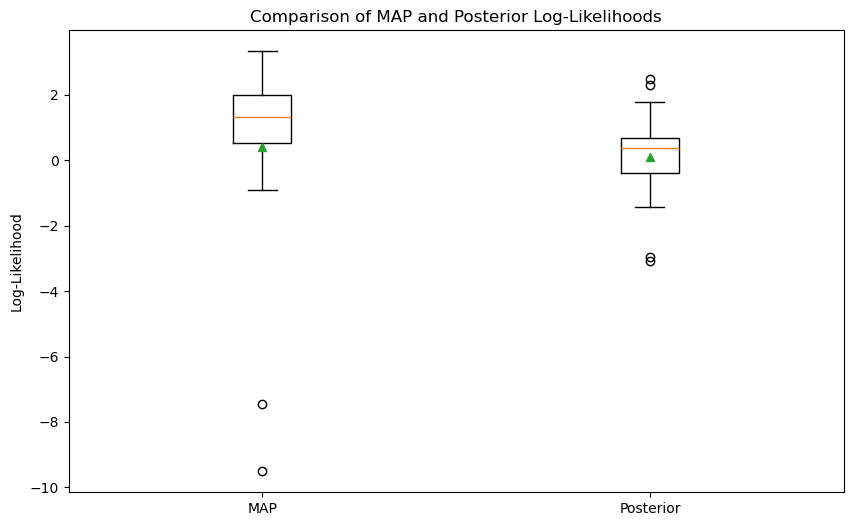

In [23]:
# Repeat for 20 datasets
num_datasets = 20
map_likelihoods = []
posterior_likelihoods = []

variance = pyro.sample("variance", pdist.LogNormal(0.0,1.0))
lengthscale = pyro.sample("lengthscale", pdist.LogNormal(-1.0, 0.5))

for i in range(num_datasets):
    pyro.clear_param_store()
    X_train, X_test, y_train, y_test = sample_datapoints(L=30,g=g,mu=0, std=0.01)


    # create GP model
    kernel = gp.kernels.Matern32(input_dim=1, variance=variance, lengthscale=lengthscale)
    gp_model =  gp.models.GPRegression(torch.tensor(X_train), torch.tensor(y_train), kernel=kernel, noise=torch.tensor(0.01)) 

    # MAP estimation
    gp_estimated, losses = map_estimation(gp_model, steps=10000)

    # Compute MAP log-likelihood
    map_ll = compute_log_likelihood(gp_estimated, torch.tensor(X_test).double(), torch.tensor(y_test).double())
    map_likelihoods.append(map_ll)

    # Sample from posterior and compute log-likelihood
    pyro.clear_param_store()
    samples, mcmc = parameter_sampling(X_train,y_train) 
    log_likelihood_list = []
    for i in range(len(samples['kernel.variance'])):
        pyro.clear_param_store()
        variance_i = samples['kernel.variance'][i]
        lengthscale_i = samples['kernel.lengthscale'][i]

        kernel = gp.kernels.Matern32(input_dim=1, variance=variance_i, lengthscale=lengthscale_i)
        gp_model = gp.models.GPRegression(torch.tensor(X_train), torch.tensor(y_train), kernel=kernel, noise=torch.tensor(0.01)) 
        log_likelihood = compute_log_likelihood(gp_model,X_test=X_test,y_test=y_test)
        log_likelihood_list.append(log_likelihood)

    posterior_likelihoods.append(np.mean(log_likelihood_list))

# Analyze results
print("MAP Likelihoods: Mean = {:.4f}, Std = {:.4f}".format(np.mean(map_likelihoods), np.std(map_likelihoods)))
print("Posterior Likelihoods: Mean = {:.4f}, Std = {:.4f}".format(np.mean(posterior_likelihoods), np.std(posterior_likelihoods)))

# Visualization
plt.figure(figsize=(10, 6))
plt.boxplot([map_likelihoods, posterior_likelihoods], labels=["MAP", "Posterior"], showmeans=True)
plt.ylabel("Log-Likelihood")
plt.title("Comparison of MAP and Posterior Log-Likelihoods")
plt.show()
